# Question 3

In [1]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

To generate the first order Bessel functions, first define a function for the integrand.

In [2]:
def f(theta, m, x):
    return np.cos(m*theta - x*np.sin(theta))

Now, we write a function to compute the integral for the Bessel functions.

In [3]:
def J(m, x):
    if type(x) == np.ndarray: # if x is an array, compute the integral for each entry
        I = np.zeros(x.shape)
        for index, val in np.ndenumerate(x):
            I[index] = integrate.quad(f, 0, np.pi, args = (m, val))[0]
    else:
        I = integrate.quad(f, 0, np.pi, args = (m, x))[0]
    return I/np.pi

Use this function to plot the first 5 Bessel functions of the first kind.

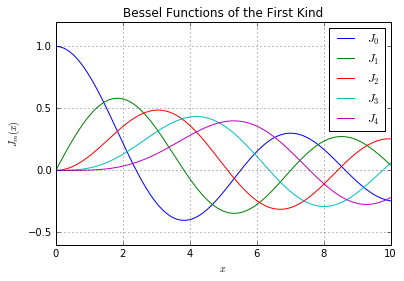

In [4]:
x = np.linspace(0,10,1000)
[plt.plot(x, J(m,x), label = '$J_'+str(m)+'$') for m in range(5)]
plt.legend()
plt.title('Bessel Functions of the First Kind')
plt.xlabel('$x$')
plt.ylabel('$J_m(x)$')
plt.xlim((0,10))
plt.grid()
plt.show()

Now define a function to compute the point spread function. Here, $a$ is the aperature, $wl$ is the wavelength, $R$ is the distance of the aperature from the focal plane, and $x$ and $y$ are the coordinates of the point to be evaluated. The focal point is centred on the origin..

In [5]:
def I1(x, y, a, wl, R, I0):
    q = np.sqrt(x**2 + y**2)
    z = 2 * np.pi * a * q / (wl * R)
    return I0 * (2 * J(1, z) / z)**2

For the sake of speed, the next function is the same as above, but uses the Bessel function built into scipy.

In [6]:
from scipy.special import jv
def I2(x, y, a, wl, R, I0):
    q = np.sqrt(x**2 + y**2)
    z = 2 * np.pi * a * q / (wl * R)
    return I0 * (2 * jv(1, z) / z)**2

Now choose some parameters to plot. In this case, we choose $a=100$ cm, $\lambda=100$ cm, $R=100$ cm, and $I_{0}=100$ erg $\cdot$ cm$^{-2} \cdot$ s$^{-1}$

In [7]:
a = 100
wl = 100
R = 100
I0 = 100

Now we can plot the function on a 2D monochrome plot. Note that the maximum value of $I$ for the colour map is only 2 erg $\cdot$ cm$^{-2} \cdot$ s$^{-1}$. This increases the image contrast and allows us to see the edge detail of the function.

In [8]:
lower = -200
upper = 200
x = np.linspace(lower, upper, 500)
xv, yv = np.meshgrid(x, x)
vals = I2(xv, yv, a, wl, R, I0)

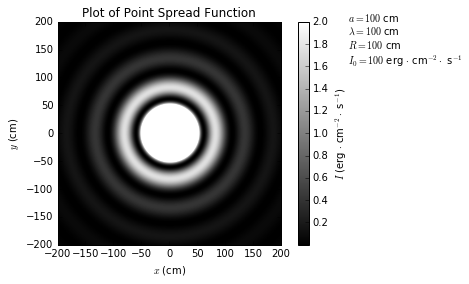

In [9]:
plt.imshow(vals, extent = [lower, upper, lower, upper], cmap = 'gray', vmax = 2)
plt.xlabel('$x$ (cm)')
plt.ylabel('$y$ (cm)')
plt.title('Plot of Point Spread Function')
plt.text(upper*1.6, upper*0.6, '$a='+str(a)+'$ cm\n$\lambda='+str(wl)+'$ cm\n$R='+str(R)+
         '$ cm\n$I_{0}='+str(I0)+'$ erg $\cdot$ cm$^{-2} \cdot$ s$^{-1}$')
clrbar = plt.colorbar()
clrbar.set_label('$I$ (erg $\cdot$ cm$^{-2} \cdot$ s$^{-1}$)')
plt.show()

We now use the point spread function to convolve an astronomical image, using scipy.signal.convolve2d().

In [10]:
from scipy import signal

Load the image and split it into its colours.

In [11]:
image = plt.imread('small.png')
h, w, d = image.shape
clrs = [image[:,:,i] for i in range(4)]

Choose some arbitrary values to input into the point spread function.

In [12]:
a = 500
R = 100
I0 = 2e-2

Create a meshgrid that roughly corresponds to the position of each pixel, and apply the point spread function to it. We use a slightly different $\lambda$ for each colour.

In [13]:
x = np.linspace(-w//2,w//2,w)
y = np.linspace(-h//2,h//2,h)
xv, yv = np.meshgrid(x, y)
k = [I2(xv, yv, a, wl, R, I0) for wl in (65, 55, 45)]

Convolve each colour with one of the $k_i$'s, and the stack each colour into one image.

In [14]:
convolved_clrs = [signal.convolve2d(clrs[i], k[i], mode = 'same') for i in range(3)]
convolved = np.stack(convolved_clrs + [clrs[3]], 2)

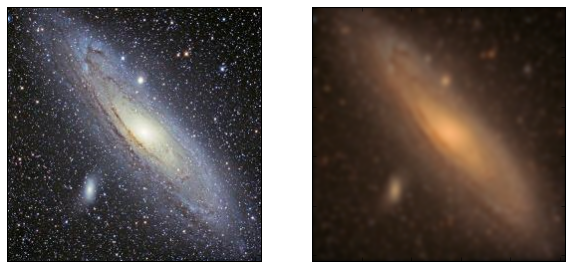

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10,10))
ax[0].imshow(image)
ax[1].imshow(convolved)
for axis in ax:
    axis.set_xticklabels([])
    axis.set_yticklabels([])
plt.show()